# DBSCAN. Практическая работа

## Цель практической работы

Научиться строить модели кластеризации с помощью метода DBSCAN.

## Что входит в работу


- Загрузите данные и проведите разведочный анализ.
- Предположите оптимальное количество кластеров.
- Постройте модель кластеризации DBSCAN.
- Определите оптимальное количество и структуру кластеров.
- Интерпретируйте полученные результаты.

## Что оценивается 

1. Выполнены все задания.
2. Сделаны выводы по результатам разведочного анализа данных.
3. Объяснены выбранные гиперпараметры модели кластеризации.
4. Сделаны выводы о количестве и структуре кластеров.
5. Сделаны выводы по результатам кластеризации.

# Задача

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды. 
* AFDP — перепад давления на воздушном фильтре. 
* GTEP — давление на выходе из газовой турбины. 
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины. 
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа. 
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import DBSCAN

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.neighbors import NearestNeighbors

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [2]:
df = pd.read_csv('data/gt_2015.csv')
df_start = df.copy()
print(df.shape)
df.head(5)

(7384, 11)


AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  1.95320  1020.1  84.985  2.5304  20.116  1048.7  544.92  116.27  10.799   
1  1.21910  1020.1  87.523  2.3937  18.584  1045.5  548.50  109.18  10.347   
2  0.94915  1022.2  78.335  2.7789  22.264  1068.8  549.95  125.88  11.256   
3  1.00750  1021.7  76.942  2.8170  23.358  1075.2  549.63  132.21  11.702   
4  1.28580  1021.6  76.732  2.8377  23.483  1076.2  549.68  133.58  11.737   

       CO      NOX  
0  7.4491  113.250  
1  6.4684  112.020  
2  3.6335   88.147  
3  3.1972   87.078  
4  2.3833   82.515

In [3]:
missing_values = df.isna().sum()
missing_percentage = (missing_values / df.shape[0]) * 100
# Объединяем в один DataFrame
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage
})
missing_info = missing_info[missing_info['Количество пропусков'] > 0]
print(missing_info)

Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []


#### Выбросы. DBSCAN очень чувствителен к выбросам в данных

<Axes: >

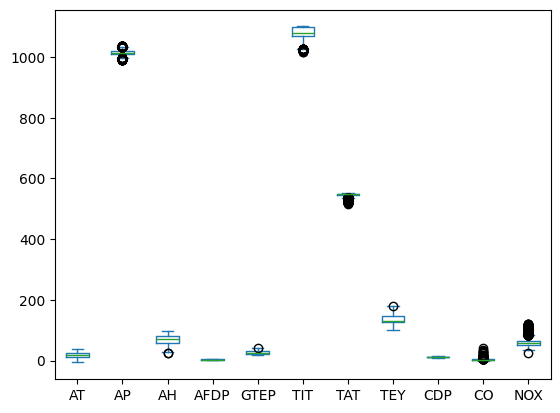

In [4]:
# Предварительно глянем на признаки
df.plot(kind='box')

In [5]:

def calculate_iqr_boundaries(series: pd.Series) -> tuple:
    """
    Вычисляет границы выбросов на основе межквартильного размаха (IQR).

    :param series: pandas Series, для которой вычисляются границы
    :return: кортеж (нижняя граница, верхняя граница)
    """
    if series.empty:
        raise ValueError("Входная серия не должна быть пустой.")

    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25

    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [6]:
# Заменим выбросы граничными значениями и сразу проверим результат

num_cols_list = df.columns
for i in num_cols_list:
    print('======', i, '=====')
    lower_bound, upper_bound = calculate_iqr_boundaries(df[i])
    
    out_l = df[df[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df[df[i] > upper_bound]  # Строки с правыми выбросами

    # ИЛИ МЕДИАНУ
    median_income = df[i].median()
    # Заменяем выбросы на медиану
    #df[i] = df[i].apply(lambda x: median_income if x < lower_bound or x > upper_bound else x)

    # Заменяем выбросы на граничные значения
    df[i] = df[i].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


    # После замены, пересчитываем границы
    lower_bound, upper_bound = calculate_iqr_boundaries(df[i])
    
    # Проверяем оставшиеся выбросы
    out_l = df[df[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df[df[i] > upper_bound]  # Строки с правыми выбросами

    print('Размах', (lower_bound, upper_bound))
    print('Количество выбросов слева:', len(out_l))
    print('Количество выбросов справа:', len(out_r))
    print('Общее количество значений:', sum(df[i].value_counts()))

    if not out_l.empty:
        print('Выбросы слева:')
        #print(out_l)

    if not out_r.empty:
        print('Выбросы справа:')
        #print(out_r)

    print('=======+++++++=======')


====== AT =====
Размах (-7.844000000000003, 42.602000000000004)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 7384
=======+++++++=======
====== AP =====
Размах (996.7375000000002, 1031.2374999999997)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 7384
=======+++++++=======
====== AH =====
Размах (29.13749999999999, 109.96350000000001)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 7384
=======+++++++=======
====== AFDP =====
Размах (1.5010125000000007, 5.811112499999999)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 7384
=======+++++++=======
====== GTEP =====
Размах (12.840124999999993, 40.32512500000001)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 7384
=======+++++++=======
====== TIT =====
Размах (1026.3999999999999, 1144.0000000000002)
Количество выбросов слева: 0
Количество выбросов с

<Axes: >

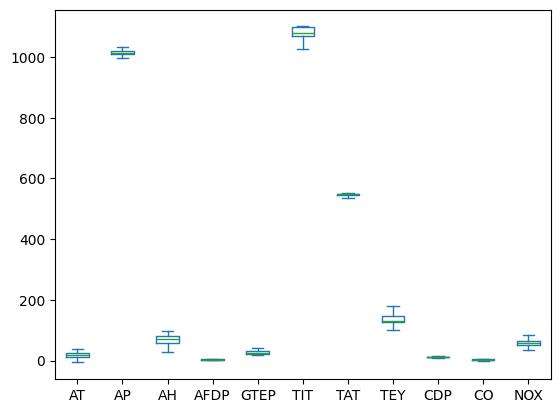

In [7]:
# Снова глянем на признаки
df.plot(kind='box')

Histogram for AT


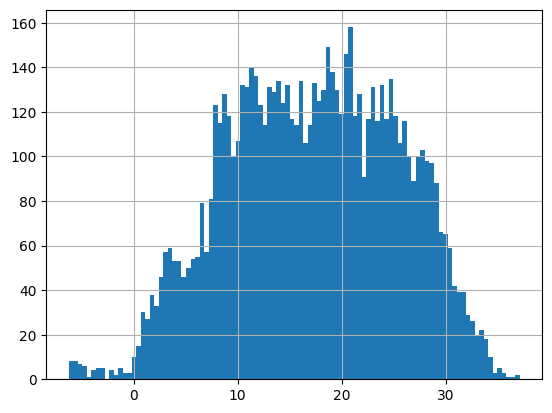

Histogram for AP


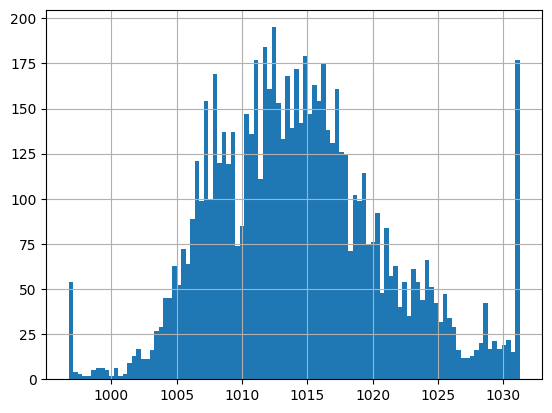

Histogram for AH


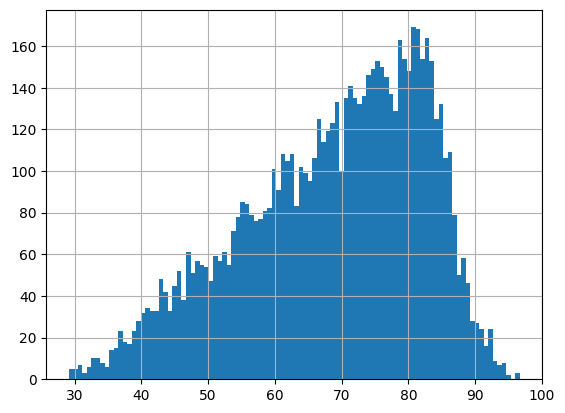

Histogram for AFDP


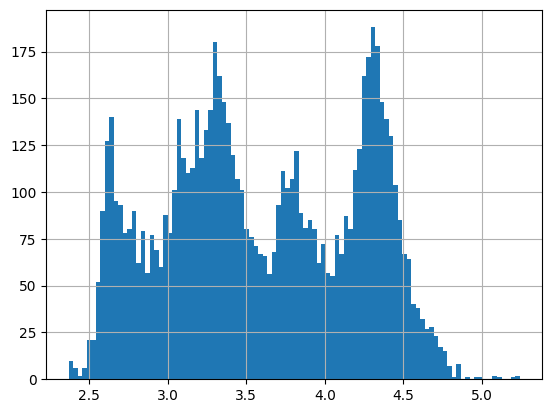

Histogram for GTEP


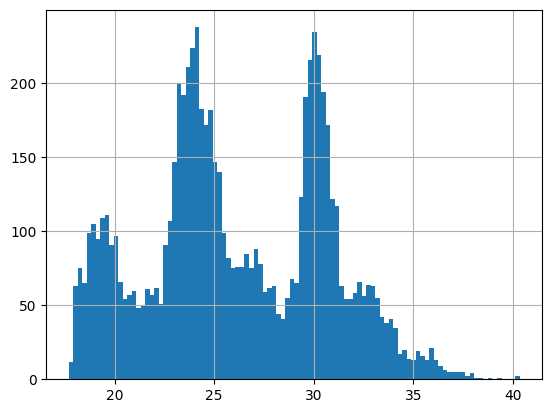

Histogram for TIT


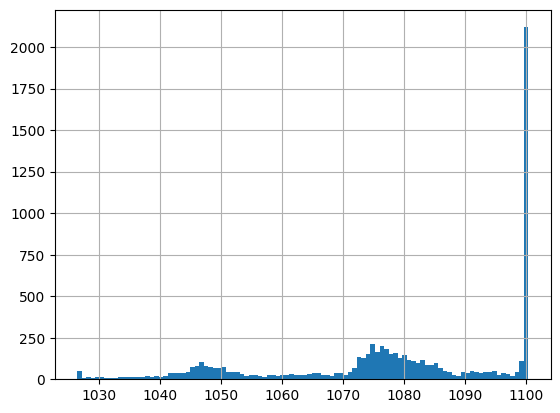

Histogram for TAT


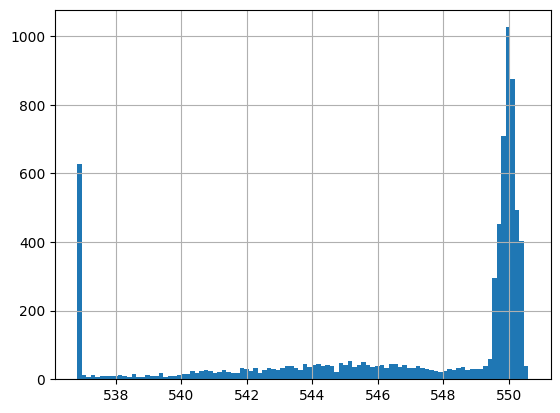

Histogram for TEY


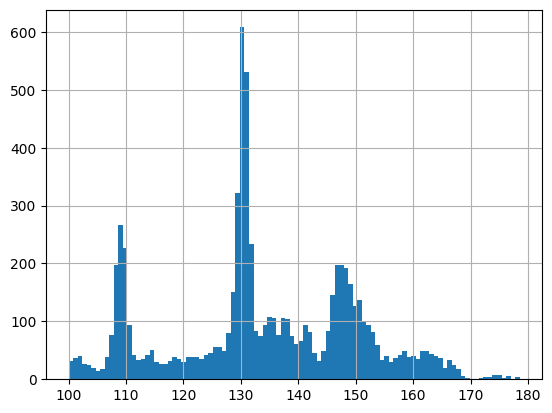

Histogram for CDP


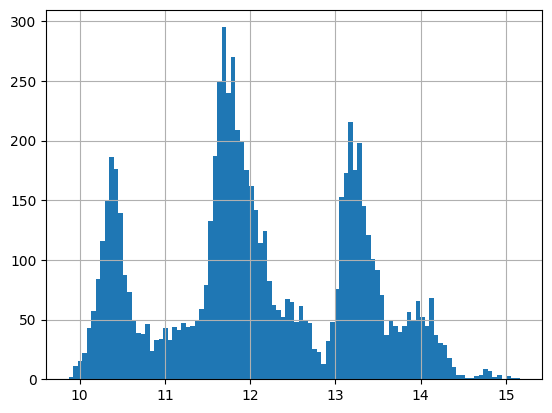

Histogram for CO


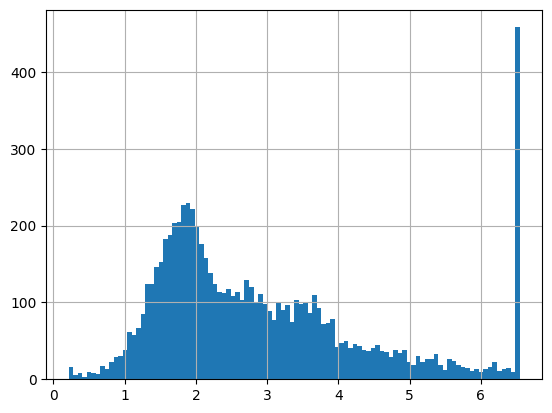

Histogram for NOX


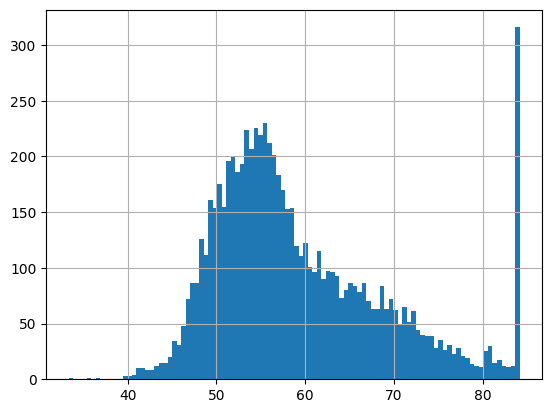

In [8]:
# Посмотрим распределения признаков
num_cols = df.select_dtypes(include=['number'])
for col in num_cols:
  print(f'Histogram for {col}')
  df[col].hist(bins=100)
  plt.show()

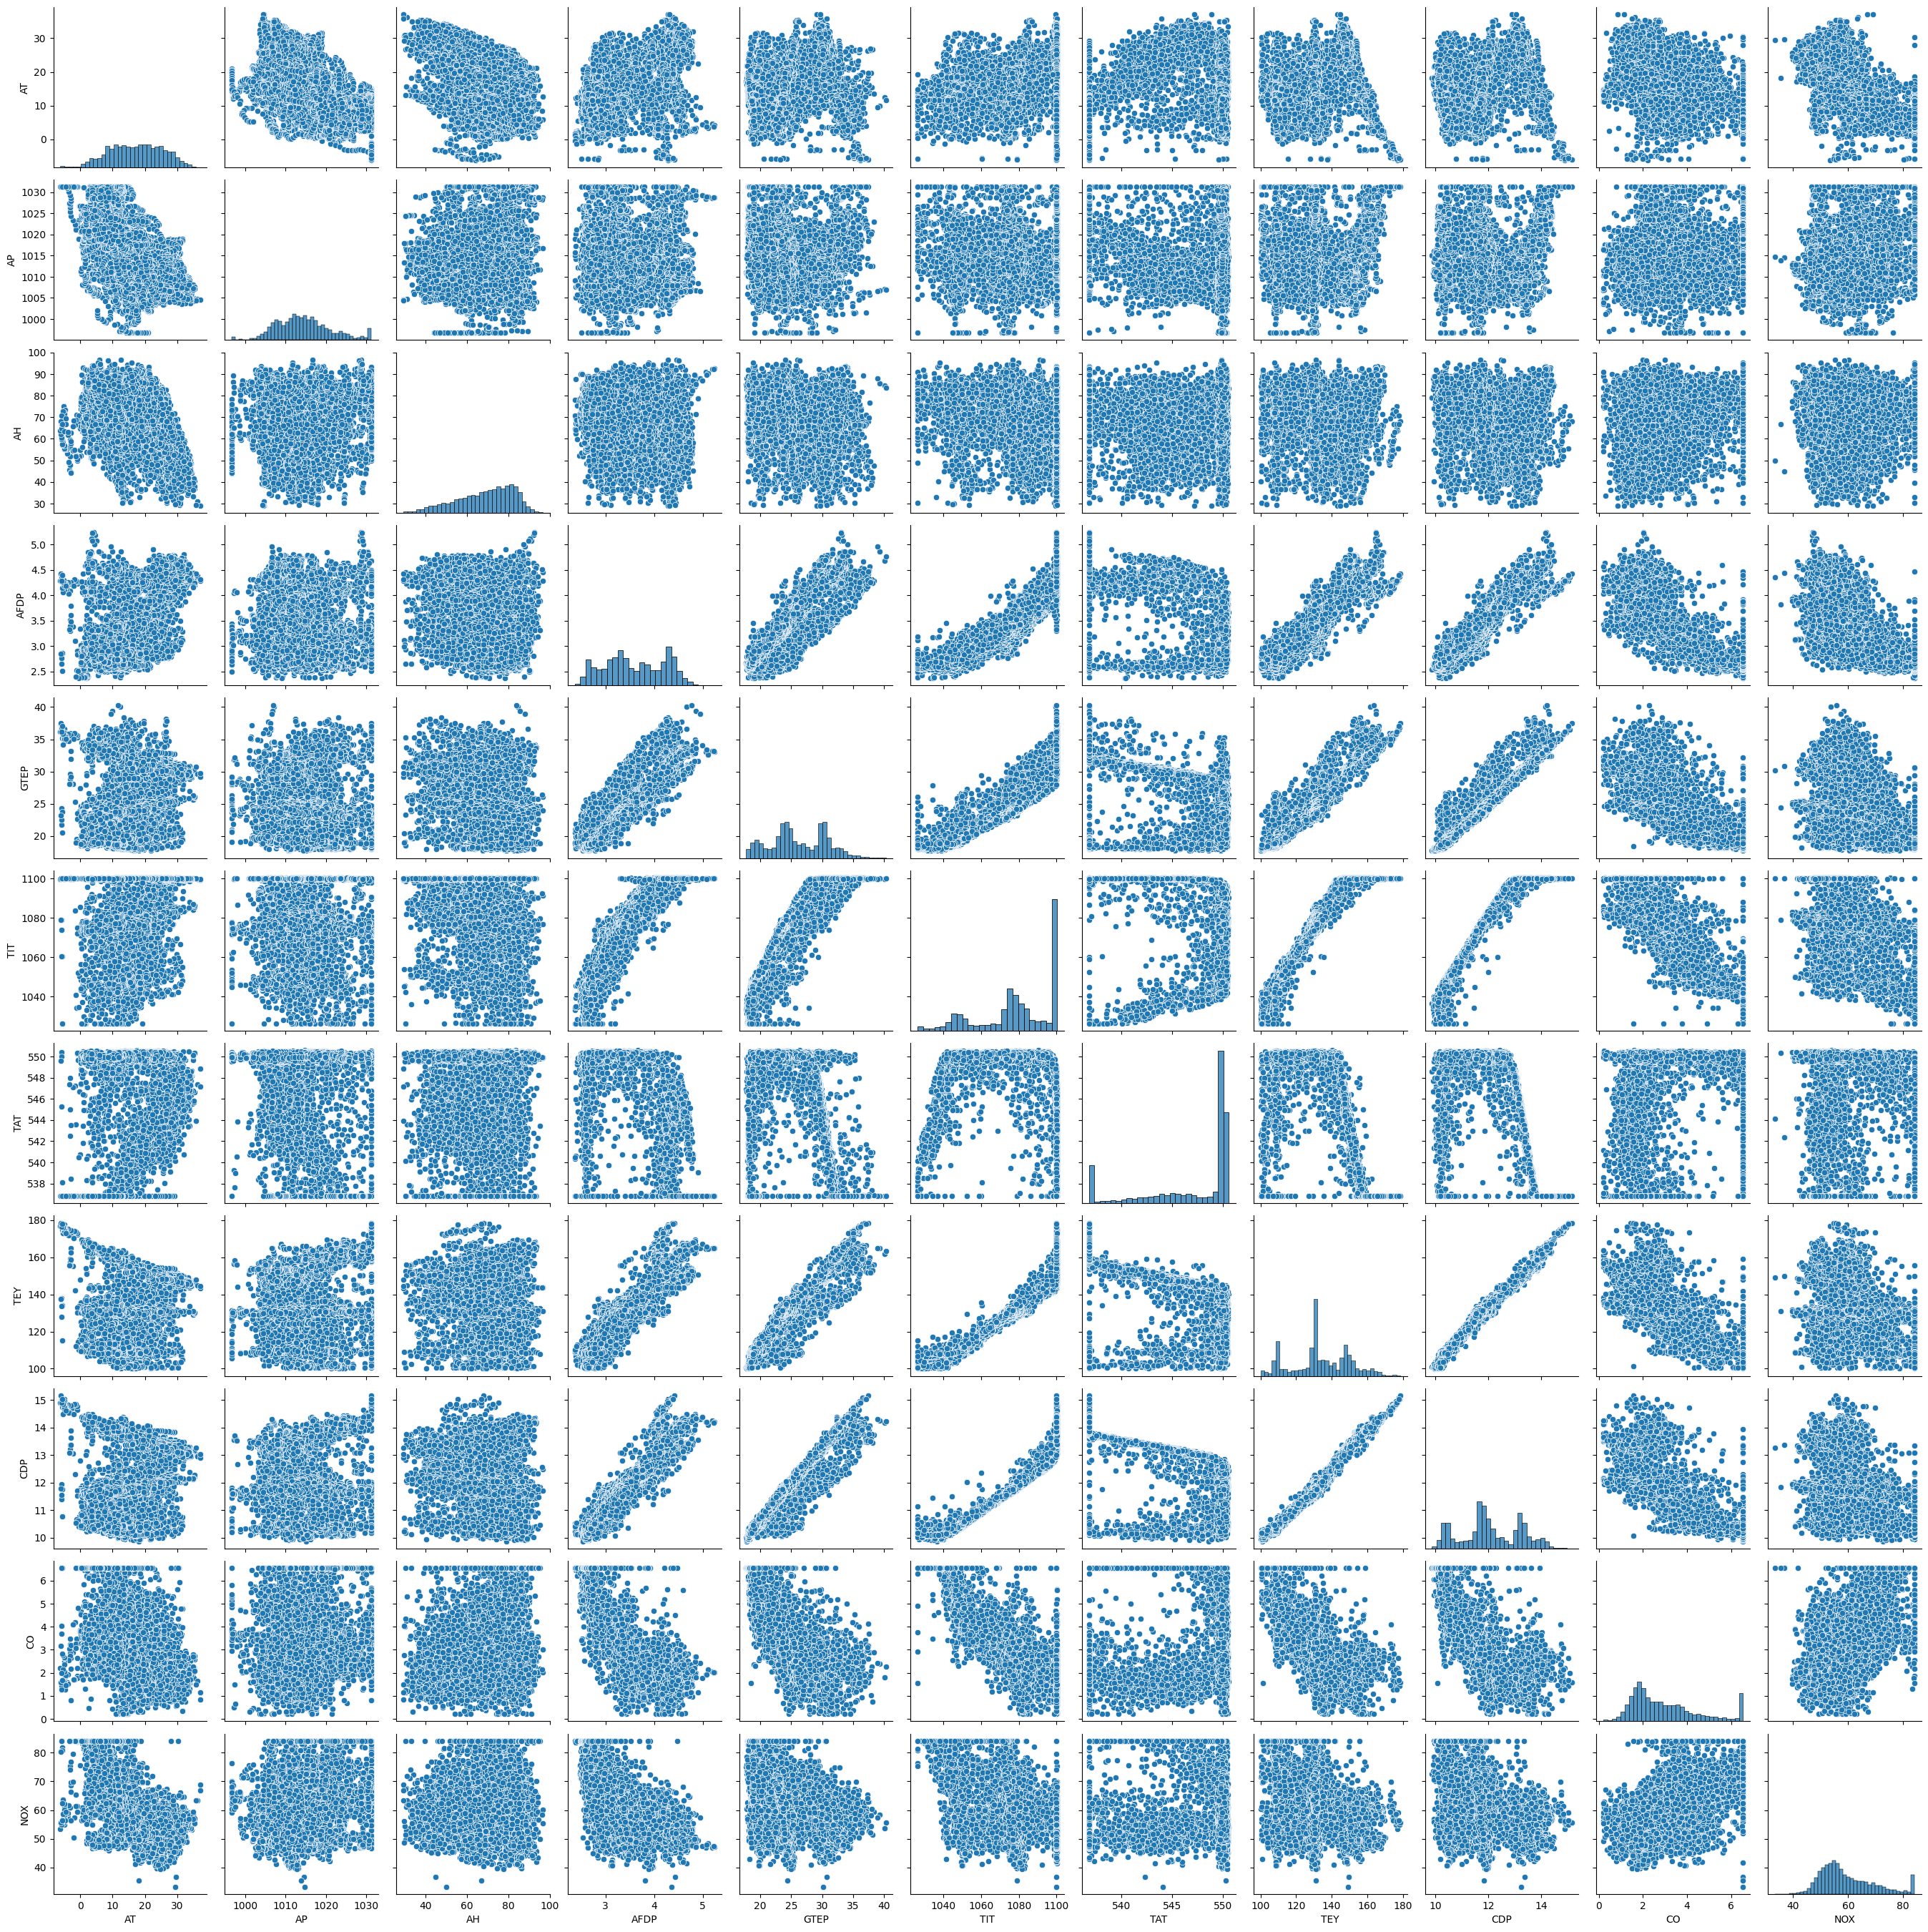

In [9]:
# Посмотрим совместные распределения признаков
sns.pairplot(df)
plt.show()

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

По результатам просмотра совместных распределений, кажутся интересными следующие признаки:

AT — температура окружающей среды.

GTEP — давление на выходе из газовой турбины. 

TEY — энергоотдача турбины.

In [10]:
df_start[['AT', 'GTEP', 'TEY']].describe()

AT         GTEP          TEY
count  7384.000000  7384.000000  7384.000000
mean     17.225259    26.130149   133.993380
std       8.095783     4.473737    16.179208
min      -6.234800    17.698000   100.020000
25%      11.073250    23.147000   126.255000
50%      17.456500    25.331000   131.600000
75%      23.684750    30.018250   147.160000
max      37.103000    40.716000   179.500000

In [11]:
# нормализуем признаки для дальнейшей работы
scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0 -1.886549  0.834618  1.206855 -1.751125 -1.344454 -1.536795 -0.480918   
1 -1.977232  0.834618  1.394353 -1.975155 -1.686933 -1.699138  0.333411   
2 -2.010579  1.146969  0.715580 -1.343871 -0.864267 -0.517081  0.663237   
3 -2.003371  1.072600  0.612671 -1.281431 -0.619703 -0.192396  0.590448   
4 -1.968993  1.057726  0.597157 -1.247506 -0.591759 -0.141664  0.601821   

        TEY       CDP        CO       NOX  
0 -1.095533 -1.142101  2.376241  2.525991  
1 -1.533789 -1.539805  2.326272  2.525991  
2 -0.501507 -0.739998  0.455282  2.525991  
3 -0.110228 -0.347573  0.167331  2.525991  
4 -0.025544 -0.316777 -0.369831  2.360095

<Axes: >

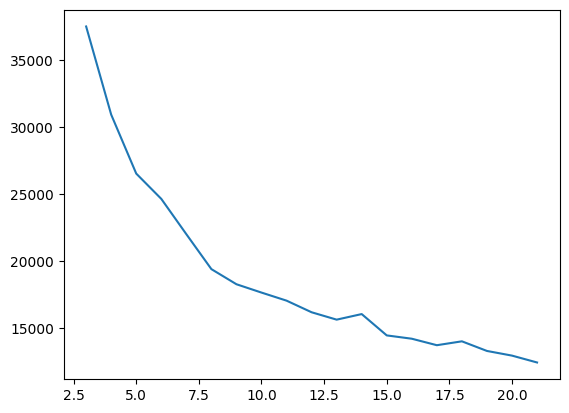

In [12]:
# Как наиболее простой и быстрый предварительный вариант предполажения количества кластеров
# Представляется использование
# метода локтя и инерции

n_clusters = list(range(3, 22))
x = df
metrics = []

for k in n_clusters:
  km = KMeans(n_clusters=k).fit(x)
  metrics.append(km.inertia_)

sns.lineplot(x=n_clusters, y=metrics)

max_score 0.3395730873316301
max_index 0
clusters 2


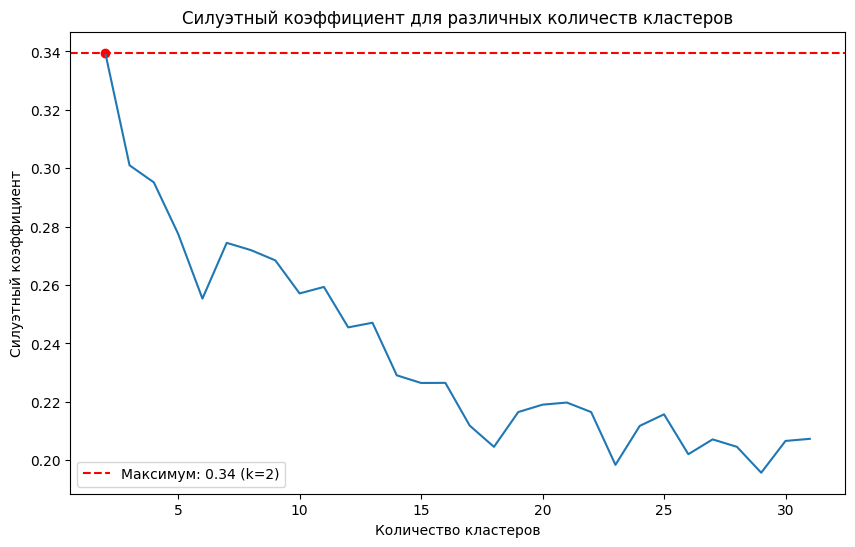

In [13]:
# Посмотрим Sihouet
n_clusters = list(range(2, 32))
metrics = []

# Вычисляем силуэтный коэффициент для разных количеств кластеров
for k in n_clusters:
    km = KMeans(n_clusters=k).fit(x)
    score = silhouette_score(x, km.labels_)
    metrics.append(score)

# Находим максимальное значение и его индекс
max_score = max(metrics)
max_index = metrics.index(max_score)
optimal_clusters = n_clusters[max_index]

print('max_score', max_score)
print('max_index', max_index)
print('clusters', optimal_clusters)

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_clusters, y=metrics)
plt.axhline(y=max_score, color='r', linestyle='--', label='Максимум: {:.2f} (k={})'.format(max_score, optimal_clusters))
plt.scatter(optimal_clusters, max_score, color='red')  # красная точка на максимуме
plt.title('Силуэтный коэффициент для различных количеств кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.legend()
plt.show()

По результатам предварительного просмотра, с помощью методов Локтя и Силуэт. Получилась неутешительная картина. Если по методу локтя можно еще хоть как-то что-то предполагать, то силуэт нам выдал на максимуме функции два кластера, что скорее всего выдаст два центроида с очень похожими представителями кластеров.

In [14]:
# предполагаем от трех до 15 кластеров

# Однако на первый взгляд наиболее перспективной кажется идея именно с пятью кластерами

Попробуем визуализировать растояния для подбора гиперпараметров DBSCAN

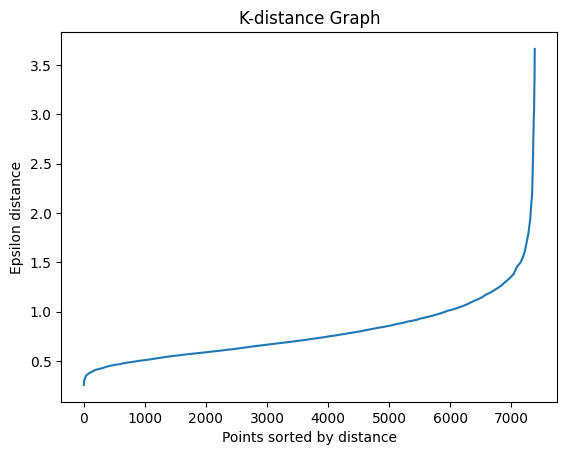

In [15]:
# Визуализация расстояний для выбора eps

k = 100

neighbors = NearestNeighbors(n_neighbors=k) # используем min_samples=5
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)
distances = np.sort(distances[:,14], axis=0)  # берем  расстояние
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.show()

имеет сравнительно стабильный наклон и затем может резко подниматься (или, возможно, иметь разрыв). Этот "излом" помогает определить оптимальное значение eps:
Плата (сравнительно горизонтальная линия) — в этом диапазоне точки распределены с небольшими расстояниями друг от друга, что указывает на высокую плотность точек.

Излом — место, где расстояние начинает резко увеличиваться, указывает на то, что соседние точки становятся менее плотными и нарастающее расстояние говорит о том, что мы начинаем доходить до точек, находящихся в разреженных областях.

Определение eps:
        Это значение обычно выбирается в месте "излома" графика. Значение eps должно быть меньше или равно этому порогу. Проще говоря, точки, находящиеся на расстоянии eps друг от друга, будут рассматриваться как принадлежащие одному кластеру.


# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.


eps: Увеличение eps, как правило, приводит к увеличению количества кластеров и снижению количества выбросов. Однако, если значение eps слишком велико, это может привести к объединению нескольких, потенциально несвязанных, кластеров. В то же время, если eps слишком мал, количество кластеров резко возрастет, так как большинство точек будет считаться выбросами.

min_samples: Увеличение min_samples делает алгоритм более строгим в определении кластера, таким образом, возможно, что некоторые менее плотные кластеры не будут обнаружены. Если min_samples уменьшить, алгоритм сможет обнаружить больше кластеров, но также может учесть шум как кластерные точки.

Параметры eps и min_samples работают в тандеме. Если увеличить eps, тогда, чтобы сохранить определенное количество кластеров, может потребоваться также увеличить min_samples. Однако это зависит от особенностей данных. Нужно настраивать оба параметра, чтобы найти оптимальные значения.


In [16]:
# возьмем дефолтные параметры
model = DBSCAN(eps=0.5, min_samples=5)
model.fit(df)

DBSCAN()

In [17]:
# Интерпретировать результаты будем по ненормализованному датасету

df_start['labels'] = model.labels_
#print(df_start.head())

In [18]:
#df_start['labels'].value_counts()

In [19]:
# Посмотрим на строки которые определились как выбросы

#outliers = df_start[df_start['labels'] == -1]
#print(outliers)

In [20]:
# Посмотрим метрику
silhouette_score(df, df_start['labels'])

-0.342987840128425


Значение близкое к 1 указывает на то, что точка находится хорошо сгруппирована в своем кластере и далеко от других кластеров.
Значение около 0 указывает на то, что точка находится на границе между двумя кластерами, и неясно, к какому из них она принадлежит.
Значение, близкое к -1, указывает на то, что точка, скорее всего, была отнесена к неправильному кластеру.


In [21]:
# Настройка гиперпараметров
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(3, 10)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df)
        n_noise = np.sum(clusters == -1)
        print(f'eps: {eps}, min_samples: {min_samples}, выбросы: {n_noise}')

eps: 0.1, min_samples: 3, выбросы: 7377
eps: 0.1, min_samples: 4, выбросы: 7384
eps: 0.1, min_samples: 5, выбросы: 7384
eps: 0.1, min_samples: 6, выбросы: 7384
eps: 0.1, min_samples: 7, выбросы: 7384
eps: 0.1, min_samples: 8, выбросы: 7384
eps: 0.1, min_samples: 9, выбросы: 7384
eps: 0.2, min_samples: 3, выбросы: 6875
eps: 0.2, min_samples: 4, выбросы: 7228
eps: 0.2, min_samples: 5, выбросы: 7318
eps: 0.2, min_samples: 6, выбросы: 7361
eps: 0.2, min_samples: 7, выбросы: 7377
eps: 0.2, min_samples: 8, выбросы: 7384
eps: 0.2, min_samples: 9, выбросы: 7384
eps: 0.30000000000000004, min_samples: 3, выбросы: 4956
eps: 0.30000000000000004, min_samples: 4, выбросы: 5824
eps: 0.30000000000000004, min_samples: 5, выбросы: 6418
eps: 0.30000000000000004, min_samples: 6, выбросы: 6769
eps: 0.30000000000000004, min_samples: 7, выбросы: 6979
eps: 0.30000000000000004, min_samples: 8, выбросы: 7102
eps: 0.30000000000000004, min_samples: 9, выбросы: 7178
eps: 0.4, min_samples: 3, выбросы: 3049
eps: 0.4


eps = 0.7, min_samples = 3: 705 выбросов — достаточно низкое количество выбросов, возможность выделения кластеров.

silhouette_df_start -0.17935437872028814
silhouette_df_encoded -0.4863417784111436

    
eps = 0.8, min_samples = 3: 427 выбросов — ещё более оптимальный вариант.

silhouette_df_start -0.3015268903802525
silhouette_df_encoded -0.5050258407732395


    
eps = 0.9, min_samples = 3: 261 выбросов — почти оптимальная конфигурация, однако возможно потеря информации о более мелких кластерах.


silhouette_df_start -0.3156503660985046
silhouette_df_encoded -0.4382443239981027

0.6   3

silhouette_df_start -0.06504769773759458
silhouette_df_encoded -0.4283017132597035





silhouette_df_start -0.06504769773759458
silhouette_df_encoded -0.4283017132597035


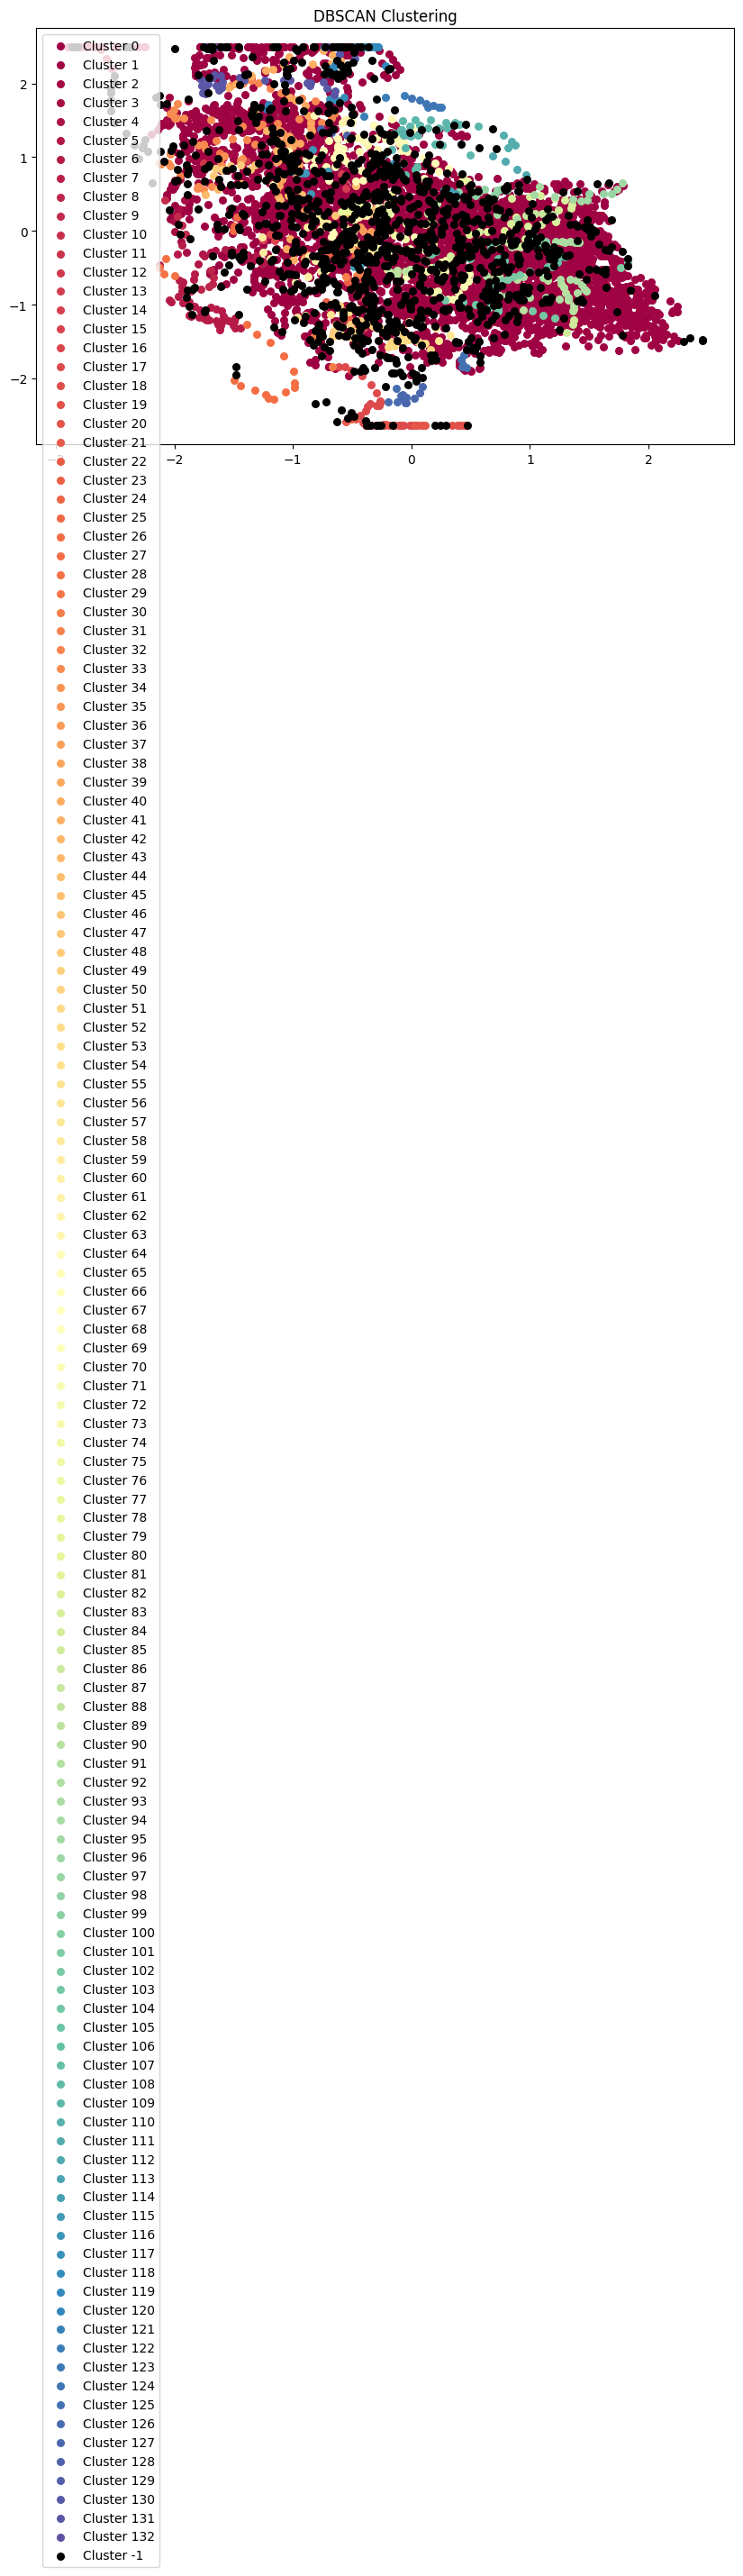

In [22]:
# Настройки гиперпараметров DBSCAN
eps = 0.6  # расстояние для соседства
min_samples = 3  # минимальное количество точек для кластеризации

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(df)
df_start['labels_tun'] = dbscan.labels_

# Визуализация кластеров
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

print('silhouette_df_start', silhouette_score(df_start, labels))
print('silhouette_df_encoded', silhouette_score(df, labels))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Черный цвет для выбросов
        col = 'k'
        
    class_member_mask = (labels == k)
    
    # Рисование кластеров
    xy = df[class_member_mask]
    #plt.scatter(xy[:, 0], xy[:, 1], color=col, s=30, label=f'Cluster {k}')
    plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], color=col, s=30, label=f'Cluster {k}')


plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


Выводы:

На мой взгляд наиболее оптимальнальная модель: 

eps = 0.6, min_samples = 3:

silhouette_score -0.06504769773759458

выбросы: 1122


Однако модель:

eps = 0.6, min_samples = 3:

при куда более низкой метрике: silhouette_score -0.3156503660985046

выдает куда меньше выбросов - выбросы: 261

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных. 

In [23]:
# разделим данные на два набора: выбросы и нормальные объекты
outliers = df_start[df_start['labels_tun'] == -1]
normal_objects = df_start[df_start['labels_tun'] != -1]

In [24]:
# вычислим средние значения по всем признакам для выбросов и нормальных объектов
outlier_means = outliers.mean()
normal_means = normal_objects.mean()

print("Средние значения выбросов (labels_tun = -1):")
print(outlier_means)

print("\nСредние значения нормальных объектов:")
print(normal_means)

Средние значения выбросов (labels_tun = -1):
AT              15.003755
AP            1014.491471
AH              67.961377
AFDP             3.382914
GTEP            25.645071
TIT           1071.846791
TAT            546.451988
TEY            129.417273
CDP             11.771590
CO               4.090901
NOX             65.085769
labels          -1.000000
labels_tun      -1.000000
dtype: float64

Средние значения нормальных объектов:
AT              17.623299
AP            1014.512271
AH              68.770394
AFDP             3.637610
GTEP            26.217063
TIT           1080.251836
TAT            546.676616
TEY            134.813309
CDP             12.155335
CO               2.957813
NOX             58.959644
labels          49.372565
labels_tun       9.417119
dtype: float64


In [25]:
#сравним средние значения выбросов и нормальных объектов
comparison = pd.concat([outlier_means, normal_means], axis=1)
comparison.columns = ['Outliers Mean', 'Normal Mean']
comparison['Difference'] = comparison['Normal Mean'] - comparison['Outliers Mean']

print("\nРазница между средними значениями выбросов и нормальных объектов:")
print(comparison)


Разница между средними значениями выбросов и нормальных объектов:
            Outliers Mean  Normal Mean  Difference
AT              15.003755    17.623299    2.619544
AP            1014.491471  1014.512271    0.020800
AH              67.961377    68.770394    0.809017
AFDP             3.382914     3.637610    0.254696
GTEP            25.645071    26.217063    0.571992
TIT           1071.846791  1080.251836    8.405045
TAT            546.451988   546.676616    0.224629
TEY            129.417273   134.813309    5.396036
CDP             11.771590    12.155335    0.383745
CO               4.090901     2.957813   -1.133088
NOX             65.085769    58.959644   -6.126125
labels          -1.000000    49.372565   50.372565
labels_tun      -1.000000     9.417119   10.417119


In [26]:
# посчитаем средние значения по кластерам
cluster_means = normal_objects.groupby('labels_tun').mean()

print("\nСредние значения по кластерам:")
print(cluster_means)


Средние значения по кластерам:
                   AT           AP         AH      AFDP       GTEP  \
labels_tun                                                           
0           16.529369  1014.615597  71.383330  3.344355  23.983323   
1           21.907004  1013.606897  65.362797  4.342193  30.869332   
2            3.321794  1022.068750  62.906813  4.073331  33.522813   
3            1.388641  1016.333333  74.217778  2.600278  20.484889   
4            4.947250  1012.316667  64.584833  3.929217  32.501333   
...               ...          ...        ...       ...        ...   
128         11.869333  1023.500000  41.492667  4.394567  32.308333   
129          3.575025  1031.975000  85.615500  2.893225  19.476750   
130         12.269750  1031.100000  78.067000  3.412300  23.654750   
131          6.479800  1027.837500  86.272250  4.041492  26.053458   
132          4.425400  1028.533333  94.151667  3.223733  18.986667   

                    TIT         TAT         TEY        CD

In [27]:
outliers = df_start[df_start['labels_tun'] == -1]
normal_objects = df_start[df_start['labels_tun'] != -1]

outlier_means = outliers.mean()
normal_means = normal_objects.mean()

print("Средние значения выбросов (labels_tun = -1):")
print(outlier_means)

print("\nСредние значения нормальных объектов:")
print(normal_means)

comparison = pd.concat([outlier_means, normal_means], axis=1)
comparison.columns = ['Outliers Mean', 'Normal Mean']
comparison['Difference'] = comparison['Normal Mean'] - comparison['Outliers Mean']

print(comparison)

cluster_means = normal_objects.groupby('labels_tun').mean()

print("\nСредние значения по кластерам:")
print(cluster_means)


Средние значения выбросов (labels_tun = -1):
AT              15.003755
AP            1014.491471
AH              67.961377
AFDP             3.382914
GTEP            25.645071
TIT           1071.846791
TAT            546.451988
TEY            129.417273
CDP             11.771590
CO               4.090901
NOX             65.085769
labels          -1.000000
labels_tun      -1.000000
dtype: float64

Средние значения нормальных объектов:
AT              17.623299
AP            1014.512271
AH              68.770394
AFDP             3.637610
GTEP            26.217063
TIT           1080.251836
TAT            546.676616
TEY            134.813309
CDP             12.155335
CO               2.957813
NOX             58.959644
labels          49.372565
labels_tun       9.417119
dtype: float64
            Outliers Mean  Normal Mean  Difference
AT              15.003755    17.623299    2.619544
AP            1014.491471  1014.512271    0.020800
AH              67.961377    68.770394    0.809017
AFDP  

Аномальные электростанции по средним значениям показателей: 

Более низкие значения температуры окружающей среды (AT) 15.00 против 17.62

Пониженные выбросы угарного газа (CO) по сравнению с нормальными объектами 4.09 против 2.96

Более высокие выбросы оксидов азота (NOX) 65.09 против 58.96

Высокие значения температуры на входе в турбину (TIT) 1071.85 против 1080.25


Кластер 0:

Низкие значения AT (16.53) и CO (3.08).

Умеренные выбросы NOX (59.53).

Кластер 1:

Больше AT (21.91) и меньше CO (1.79) по сравнению с кластером 0.

Высокая температура на входе в турбину (TIT = 1099.86) 

Высокие выбросы NOX (53.08).

Кластер 2:

Уникальное значение AFDP (4.07) 

Повышенное значение CO (2.64) 

И более низкому уровню энергии (TEY = 166.70).

Кластер 3:

Самые низкие значения всех показателей:

 AT (1.39), 
 
 TIT (1053.94),  
 
 NOX (84.17)

Кластер 4:

Средний уровень показателей, близкий к кластеру 1, 

но с относительно  низким показателем NOX = 64.28

#### Выводы о проделанной работе:

Замена выбросов на граничные значения квантилей вместо медианы дало более лучший результат

Gridsearch оказался бесполезен

из отрицательных значений silhouette_score выбраться неудалось, однако была получена метрика -0.06504769773759458

Выводы о гиперпараметрах:

На мой взгляд наиболее оптимальнальная модель: 

eps = 0.6, min_samples = 3:

silhouette_score -0.06504769773759458

выбросы: 1122


Однако модель:

eps = 0.6, min_samples = 3:

при куда более низкой метрике: silhouette_score -0.3156503660985046

выдает куда меньше выбросов - выбросы: 261

в данном случае ориентировался на значение метрики




**Как отправить работу на проверку**

Скачайте файл с работой в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint на вкладке меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.
